In [2]:
from sympy import *

init_printing()
m,t = symbols('m t', real=True, positive=True)

# Ladder filter

*Taken from Vadim Zavalishin's* The Art of VA Filter Design [1].

The ladder filter is one of the most recognizable filter sounds out there. It is featured on Moog synths and pedals, as well as the TB-303, and has had many clones over since. Almost every flagship software synth, probably including one you own, has a ladder filter implementation.

[1]: https://www.kvraudio.com/forum/viewtopic.php?t=350246

Two approaches are valid in modeling the ladder filter -- either coming from deriving the electrical equations, or structurally matching the filter and directly deriving discrete equations from them. In the book, Zavalishin takes the latter approach and arrives on a structure for an [OTA] lowpass ladder filter structure that we'll build up using the `sympy` library.

[OTA]: https://en.wikipedia.org/wiki/Operational_transconductance_amplifier

We begin with the single integrator, discritized with the Trapezoidal method. It has a single input and output, and holds one value of state within, corresponding to the last input and last output. Its discrete equation is as follows:

In [3]:
integrator = lambda x,y: y(t-1) + m*x(t) + (1-m)*x(t-1)

x, y = symbols('x y', cls=Function, real=True)
Eq(y(t), integrator(x,y))

We can simplify the notation a little bit by introducing $u$, the function holding the internal state of the integrator:

In [4]:
u = symbols('u', cls=Function, real=True)
u_eq = Eq(u(t), y(t) - m*x(t))
u_eq

In [5]:
k,v = next(iter(solve(u_eq, y(t), dict=True)[0].items()))
Eq(k,v)

In [6]:
u_eq = u_eq.subs(y(t), integrator(x,y))

In [7]:
Eq(y(t), integrator(x,y).subs(u_eq.rhs, u_eq.lhs))

And we'll drop the functional notation, implying every variable is implicitely time-varying (the $g$ parameter will become useful later):

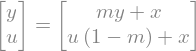

In [8]:
integrator_u = lambda g,x,y: g*(1-m)*x + y
integrator_y = lambda g,u,x: u + g*m*x

x, y, u = symbols('x y u', real=True)
Eq(Matrix([y,u]), Matrix([integrator_y(1,x,y), integrator_u(1,u,x)]))

With this, we can now write the general equations for a 4-pole ladder filter, based on the block diagram structure in the book:

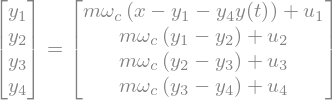

In [9]:
from functools import partial
from itertools import accumulate


x = Symbol('x', real=True)
y = symbols('y_{1:5}', seq=True, real=True)
u = symbols('u_{1:5}', seq=True, real=True)
wc, Q = symbols('omega_c Q', real=True, positive=True)
Y = Matrix(y)
U = Matrix(u)

def ladder(x, Y, U, wc, integrator=integrator_y):
    f = lambda i,x: integrator(wc, U[i], x)
    # fwd = lambda x: Matrix(list(accumulate(range(4), lambda acc,i: f(i, acc), initial=x)))
    fwd = Matrix([f(i, yy) for i,yy in enumerate([x - Y[0], Y[0] - Y[1], Y[1] - Y[2], Y[2] - Y[3]])])
    return fwd

ladder_eq = Eq(Y, ladder(x-k*Y[3], Y, U, wc))
ladder_eq

And we can solve for each state input:

In [10]:
solve(ladder_eq, U)

## OTA non-linearities
What's missing is the addition of nonlinearities, which are the most important factor to the sound of their physical counterpart. I have tested the `tanh` and hyperbolic saturators as defined in the book, but the `tanh` one sounded best. We'll keep the nonlinearities generic here, and substitute only in the end.

We'll define a generic `sat` function that encodes the nice-to-have properties of a saturator function; that is linearity around 0 ($f(0) = 0$, $f'(0) = 1$, $f''(0) = 0$), as it will help with solving equations later down the line:

In [11]:
class sat(Function):
    @classmethod
    def eval(cls, x):
        if x == 0:
            return 1

    def fdiff(self, argindex=1):
        x = self.args[0]
        if x == 0:
            return 1
        return satdiff(x)


class satdiff(Function):
    @classmethod
    def eval(cls, x):
        if x == 0:
            return 1

    def fdiff(self, argindex=1):
        if x == 0:
            return 0
        return Function('sat\'\'', real=True)

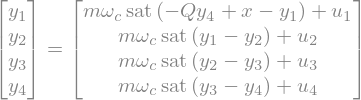

In [12]:
ota_integrator_y = lambda g,u,x: integrator_y(g,u,sat(x))
ota_ladder_eq = Eq(Y, ladder(x-Q*Y[3], Y, U, wc, integrator=ota_integrator_y))
ota_ladder_eq

Giving us the general equation for the discretized OTA ladder filter, solved for the output values; and with the output values, we can then update the integrator states:

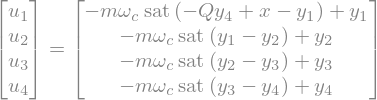

In [13]:
sol_dict = solve(ota_ladder_eq, U)
sol_k = list(sol_dict)
sol_v = [sol_dict[k] for k in sol_k]
Eq(Matrix(sol_k), Matrix(sol_v))

## Transistor ladder

The change in structure from the OTA ladder to the transistor ladder is that the nonlinearity is now in the feedback path of each integrator, as well as on the input to the next stage.

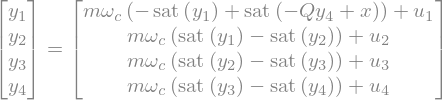

In [14]:
transistor_ladder_eq = Eq(Y, ladder(sat(x-Q*Y[3]), Matrix([sat(y) for y in Y]), U, wc))
transistor_ladder_eq

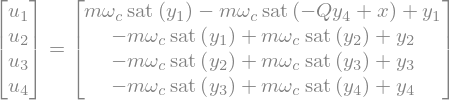

In [15]:
sol_dict = solve(transistor_ladder_eq, U)
sol_k = list(sol_dict)
sol_v = [sol_dict[k] for k in sol_k]
Eq(Matrix(sol_k), Matrix(sol_v))

## Numerical solve

Because the filter has a number of zero-delay feedback paths, it is useful to provide a way to numerically refine the solution. As in the book, we'll use the multidimensional Newton-Rhapson method, where for an implicit equation $\Phi(\vec{x}) = \vec{0}$, we construct the recurrence equation:

$$ \vec{y}_{n+1} = \vec{y}_n - J^{-1} \left( \Phi \right) \Phi \left(\vec{y}_n \right) $$

Where $J \left(\Phi\right)$ is the Jacobian matrix[2] of $\Phi$.

We'll define the difference $\vec{y}_{n} - \vec{y}_{n-1}$ as $S_\text{NR} = - J^{-1} \left( \Phi \right) \Phi \left(\vec{y}_n \right)$ that evaluates the iterative offset to the current $\vec{y}$; we can then place an exit condition $\left \| S_\text{NR} \right \| < 10^{-3}$ where $10^{-3} \equiv -60\, \text{dB}$.

Secondly, there is a choice of solving for the integrator inputs $u_{1..4}$ or the outputs $y_{1..4}$. Solving for the outputs is the most intuitive, and is the direction we'll take here.

[2]: https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant

### Solving for the OTA Ladder

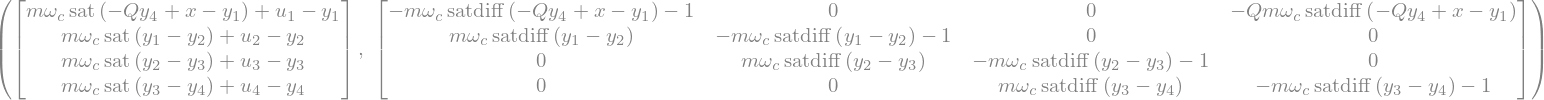

In [34]:
phi = ota_ladder_eq.rhs - Y
# Eq(step, nr_step(phi, phi.jacobian(Y)))
phi, phi.jacobian(Y)

### Solving for the Transistor Ladder

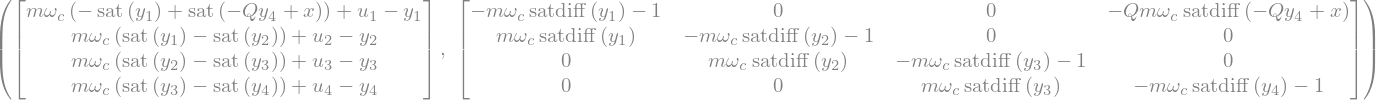

In [32]:
phi = transistor_ladder_eq.rhs - Y
# Eq(step, nr_step(phi, phi.jacobian(Y)))
phi, phi.jacobian(Y)